# Waymo Open Dataset Occupancy and Flow Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates:

- How to decode and interpret the data in the WOD Motion dataset.
- How to construct ground-truth occupancy grids and flow fields.
- How to train a simple model with Tensorflow.
- How to run inference on the test set and store the results into a protobuf for submission.

Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

# Installation

To run a Jupyter kernel locally, run:

```
$ pip install "waymo_open_dataset_tf_2_6_0==1.4.3"
$ pip install "notebook>=5.3"
$ jupyter notebook
```

In [51]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo Open
# Dataset (motion) webpage.

# Replace this path with your own tfrecords.
DATASET_FOLDER = './uncompressed'

# TFRecord dataset.
TRAIN_FILES = f'{DATASET_FOLDER}/tf_example/training/training_tfexample.tfrecord*'
# TRAIN_FILES = 'training.tfrecord*'
VAL_FILES = f'{DATASET_FOLDER}/tf_example/validation/validation_tfexample.tfrecord*'
TEST_FILES = f'{DATASET_FOLDER}/tf_example/testing/testing_tfexample.tfrecord*'


# Text files containing validation and test scenario IDs for this challenge.
VAL_SCENARIO_IDS_FILE = f'{DATASET_FOLDER}/occupancy_flow_challenge/validation_scenario_ids.txt'
TEST_SCENARIO_IDS_FILE = f'{DATASET_FOLDER}/occupancy_flow_challenge/testing_scenario_ids.txt'

In [52]:
import pathlib
import os
from typing import Dict, List, Mapping, Optional, Sequence, Tuple, Union
import uuid
import zlib

from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# import tensorflow_graphics.image.transformer as tfg_transformer

from google.protobuf import text_format
from waymo_open_dataset.protos import occupancy_flow_metrics_pb2
from waymo_open_dataset.protos import occupancy_flow_submission_pb2
from waymo_open_dataset.protos import scenario_pb2
from waymo_open_dataset.utils import occupancy_flow_data
from waymo_open_dataset.utils import occupancy_flow_grids
# from waymo_open_dataset.utils import occupancy_flow_metrics
from waymo_open_dataset.utils import occupancy_flow_renderer
from waymo_open_dataset.utils import occupancy_flow_vis

# Create dataset

In [53]:

filenames = tf.io.matching_files(TRAIN_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')
dataset = dataset.repeat()
dataset = dataset.map(occupancy_flow_data.parse_tf_example)
dataset = dataset.batch(1)
it = iter(dataset)

TypeError: dataset length is infinite.

## Load one example

In [5]:
inputs = next(it)
# print(inputs)
# for i in range(10000):
#     print(inputs['roadgraph_samples/type'][0,i,0])
# for i in range(128):
#     print(inputs['state/future/height'][0, i])

# Visualize TF Example sample

## Generate visualization images

In [9]:
def create_figure_and_axes(size_pixels):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())

  # Sets output image to pixel resolution.
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax


def fig_canvas_image(fig):
  """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


def get_colormap(num_agents):
  """Compute a color map array of shape [num_agents, 4]."""
  colors = plt.cm.get_cmap('jet', num_agents)
  colors = colors(range(num_agents))
  np.random.shuffle(colors)
  return colors


def get_viewport(all_states, all_states_mask):
  """Gets the region containing the data.

  Args:
    all_states: states of agents as an array of shape [num_agents, num_steps,
      2].
    all_states_mask: binary mask of shape [num_agents, num_steps] for
      `all_states`.

  Returns:
    center_y: float. y coordinate for center of data.
    center_x: float. x coordinate for center of data.
    width: float. Width of data.
  """
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y)
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width


def visualize_one_step(
    states,
    mask,
    roadgraph,
    title,
    center_y,
    center_x,
    width,
    color_map,
    size_pixels=1000,
):
  """Generate visualization for a single step."""

  # Create figure and axes.
  fig, ax = create_figure_and_axes(size_pixels=size_pixels)

  # Plot roadgraph.
  rg_pts = roadgraph[:, :2].T
  ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)

  masked_x = states[:, 0][mask]
  masked_y = states[:, 1][mask]
  colors = color_map[mask]

  # Plot agent current position.
  ax.scatter(
      masked_x,
      masked_y,
      marker='o',
      linewidths=3,
      color=colors,
  )

  # Title.
  ax.set_title(title)

  # Set axes.  Should be at least 10m on a side.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  image = fig_canvas_image(fig)
  plt.close(fig)
  return image


def visualize_all_agents_smooth(
    decoded_example,
    size_pixels=1000,
):
  """Visualizes all agent predicted trajectories in a serie of images.

  Args:
    decoded_example: Dictionary containing agent info about all modeled agents.
    size_pixels: The size in pixels of the output image.

  Returns:
    T of [H, W, 3] uint8 np.arrays of the drawn matplotlib's figure canvas.
  """
  # [num_agents, num_past_steps, 2] float32.
  past_states = tf.stack(
      [decoded_example['state/past/x'], decoded_example['state/past/y']],
      -1).numpy()
  past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

  # [num_agents, 1, 2] float32.
  current_states = tf.stack(
      [decoded_example['state/current/x'], decoded_example['state/current/y']],
      -1).numpy()
  current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

  # [num_agents, num_future_steps, 2] float32.
  future_states = tf.stack(
      [decoded_example['state/future/x'], decoded_example['state/future/y']],
      -1).numpy()
  future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

  # [num_points, 3] float32.
  roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()

  num_agents, num_past_steps, _ = past_states.shape
  num_future_steps = future_states.shape[1]

  color_map = get_colormap(num_agents)

  # [num_agents, num_past_steps + 1 + num_future_steps, depth] float32.
  all_states = np.concatenate([past_states, current_states, future_states], 1)

  # [num_agents, num_past_steps + 1 + num_future_steps] float32.
  all_states_mask = np.concatenate(
      [past_states_mask, current_states_mask, future_states_mask], 1)

  center_y, center_x, width = get_viewport(all_states, all_states_mask)

  images = []

  # Generate images from past time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(past_states, num_past_steps, 1),
          np.split(past_states_mask, num_past_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz,
                            'past: %d' % (num_past_steps - i), center_y,
                            center_x, width, color_map, size_pixels)
    images.append(im)

  # Generate one image for the current time step.
  s = current_states
  m = current_states_mask

  im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, 'current', center_y,
                          center_x, width, color_map, size_pixels)
  images.append(im)

  # Generate images from future time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(future_states, num_future_steps, 1),
          np.split(future_states_mask, num_future_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz,
                            'future: %d' % (i + 1), center_y, center_x, width,
                            color_map, size_pixels)
    images.append(im)

  return images

inputs_no_batch = {k: v[0] for k, v in inputs.items()}
images = visualize_all_agents_smooth(inputs_no_batch)

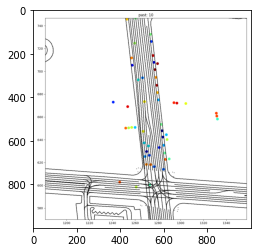

In [6]:
idx = 0
plt.imshow(images[idx])
plt.savefig("./ori_img/{}.png".format(idx))

## Display animation

In [10]:
def create_animation(images, interval=100):
  """ Creates a Matplotlib animation of the given images.

  Args:
    images: A list of numpy arrays representing the images.
    interval: Delay between frames in milliseconds.

  Returns:
    A matplotlib.animation.Animation.

  Usage:
    anim = create_animation(images)
    anim.save('/tmp/animation.avi')
    HTML(anim.to_html5_video())
  """

  plt.ioff()
  fig, ax = plt.subplots()
  dpi = 100
  size_inches = 1000 / dpi
  fig.set_size_inches([size_inches, size_inches])
  plt.ion()

  def animate_func(i):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')

  anim = animation.FuncAnimation(
      fig, animate_func, frames=len(images), interval=interval)
  plt.close(fig)
  return anim


anim = create_animation(images[::5])
HTML(anim.to_html5_video())

# Config

In [6]:
config = occupancy_flow_metrics_pb2.OccupancyFlowTaskConfig()
config_text = """
num_past_steps: 10
num_future_steps: 80
num_waypoints: 8
cumulative_waypoints: false
normalize_sdc_yaw: true
grid_height_cells: 256
grid_width_cells: 256
sdc_y_in_grid: 192
sdc_x_in_grid: 128
pixels_per_meter: 3.2
agent_points_per_side_length: 48
agent_points_per_side_width: 16
"""
text_format.Parse(config_text, config)
config

num_past_steps: 10
num_future_steps: 80
num_waypoints: 8
cumulative_waypoints: false
grid_height_cells: 256
grid_width_cells: 256
sdc_y_in_grid: 192
sdc_x_in_grid: 128
pixels_per_meter: 3.200000047683716
agent_points_per_side_length: 48
agent_points_per_side_width: 16
normalize_sdc_yaw: true

# Occupancy flow ground truth

## Generate

In [7]:
inputs = occupancy_flow_data.add_sdc_fields(inputs)

In [12]:
import sys
sys.getsizeof(inputs)

2288

In [8]:
timestep_grids = occupancy_flow_grids.create_ground_truth_timestep_grids(
    inputs=inputs, config=config)
print(timestep_grids.vehicles.future_observed_occupancy.shape)

(1, 256, 256, 80)


In [9]:
true_waypoints = occupancy_flow_grids.create_ground_truth_waypoint_grids(
    timestep_grids=timestep_grids, config=config)
print(len(true_waypoints.vehicles.observed_occupancy))
print(true_waypoints.vehicles.observed_occupancy[0].shape)
print(true_waypoints.vehicles.occluded_occupancy[0].shape)
print(true_waypoints.vehicles.flow[0].shape)
print(true_waypoints.vehicles.flow_origin_occupancy[0].shape)

save_file = {}
observed = []
occluded = []
flow = []
flow_origin_occupancy = []

for i in range(len(true_waypoints.vehicles.observed_occupancy)):
    observed.append(np.expand_dims(np.array(true_waypoints.vehicles.observed_occupancy[i], dtype = np.float), -1))
    occluded.append(np.expand_dims(np.array(true_waypoints.vehicles.occluded_occupancy[i], dtype = np.float), -1))
    flow.append(np.expand_dims(np.array(true_waypoints.vehicles.flow[i], dtype = np.float), -1))
    flow_origin_occupancy.append(np.expand_dims(np.array(true_waypoints.vehicles.flow_origin_occupancy[i], dtype = np.float), -1))
    
save_file["observed"] = np.concatenate(observed, -1)
save_file["occluded_save"] = np.concatenate(occluded, -1)
save_file["flow_save"] = np.concatenate(flow, -1)
save_file["flow_origin_occupancy_save"] = np.concatenate(flow_origin_occupancy, -1)



8
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 2)
(1, 256, 256, 1)


In [10]:
vis_grids = occupancy_flow_grids.create_ground_truth_vis_grids(
    inputs=inputs, timestep_grids=timestep_grids, config=config)
print(vis_grids.roadgraph.shape)
print(vis_grids.agent_trails.shape)

(1, 256, 256, 1)
(1, 256, 256, 1)


## Visualize

In [21]:
# Visualize waypoint 4 out of 8.
k = 3
observed_occupancy_grids = true_waypoints.get_observed_occupancy_at_waypoint(k)
observed_occupancy_rgb = occupancy_flow_vis.occupancy_rgb_image(
    agent_grids=observed_occupancy_grids,
    roadgraph_image=vis_grids.roadgraph,
)

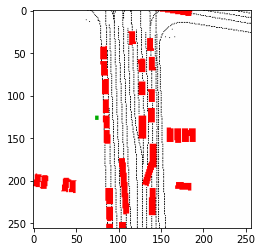

In [22]:
plt.imshow(observed_occupancy_rgb[0])

In [23]:
occluded_occupancy_grids = true_waypoints.get_occluded_occupancy_at_waypoint(k)
occluded_occupancy_rgb = occupancy_flow_vis.occupancy_rgb_image(
    agent_grids=occluded_occupancy_grids,
    roadgraph_image=vis_grids.roadgraph,
)

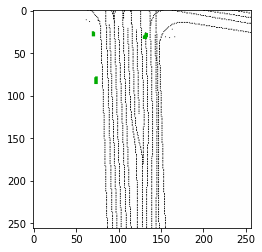

In [24]:
plt.imshow(occluded_occupancy_rgb[0])

In [25]:
flow_rgb = occupancy_flow_vis.flow_rgb_image(
    flow=true_waypoints.vehicles.flow[k],
    roadgraph_image=vis_grids.roadgraph,
    agent_trails=vis_grids.agent_trails,
)

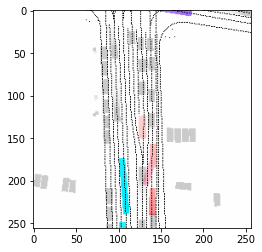

In [26]:
plt.imshow(flow_rgb[0])

In [20]:
images = []
for k in range(config.num_waypoints):
  observed_occupancy_grids = true_waypoints.get_observed_occupancy_at_waypoint(
      k)
  observed_occupancy_rgb = occupancy_flow_vis.occupancy_rgb_image(
      agent_grids=observed_occupancy_grids,
      roadgraph_image=vis_grids.roadgraph,
  )
  images.append(observed_occupancy_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

In [21]:
images = []
for k in range(config.num_waypoints):
  occluded_occupancy_grids = true_waypoints.get_occluded_occupancy_at_waypoint(
      k)
  occluded_occupancy_rgb = occupancy_flow_vis.occupancy_rgb_image(
      agent_grids=occluded_occupancy_grids,
      roadgraph_image=vis_grids.roadgraph,
  )
  images.append(occluded_occupancy_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

In [ ]:
images = []
for k in range(config.num_waypoints):
  flow_rgb = occupancy_flow_vis.flow_rgb_image(
      flow=true_waypoints.vehicles.flow[k],
      roadgraph_image=vis_grids.roadgraph,
      agent_trails=vis_grids.agent_trails,
  )
  images.append(flow_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

# Baseline model

Note that this is a very simple model to demonstrate training.

Suggestion for a stronger model:  Replace the convnet encoder with a point-based encoder like Transformer or Point Pillars and feed it points from the scene with rich features.  See function `_sample_agent_points()` in [occupancy_flow_renderer.py](https://github.com/waymo-research/waymo-open-dataset/blob/master/utils/occupancy_flow_renderer.py) for ideas on how to obtain such points and features.

Relevant publications:

- [Scene Transformer](https://arxiv.org/pdf/2106.08417.pdf)
- [Occupancy Flow Fields](https://arxiv.org/pdf/2203.03875.pdf)

In [11]:
# Number of channels output by the model.
# Occupancy of currently-observed vehicles: 1 channel.
# Occupancy of currently-occluded vehicles: 1 channel.
# Flow of all vehicles: 2 channels.
NUM_PRED_CHANNELS = 4

In [12]:
def _make_model_inputs(
    timestep_grids: occupancy_flow_grids.TimestepGrids,
    vis_grids: occupancy_flow_grids.VisGrids,
) -> tf.Tensor:
  """Concatenates all occupancy grids over past, current to a single tensor."""
  model_inputs = tf.concat(
      [
          vis_grids.roadgraph,
          timestep_grids.vehicles.past_occupancy,
          timestep_grids.vehicles.current_occupancy,
          tf.clip_by_value(
              timestep_grids.pedestrians.past_occupancy +
              timestep_grids.cyclists.past_occupancy, 0, 1),
          tf.clip_by_value(
              timestep_grids.pedestrians.current_occupancy +
              timestep_grids.cyclists.current_occupancy, 0, 1),
      ],
      axis=-1,
  )
  return model_inputs

In [13]:
def _make_model(
    model_inputs: tf.Tensor,
    config: occupancy_flow_metrics_pb2.OccupancyFlowTaskConfig,
) -> tf.keras.Model:
  """Simple convolutional model."""
  inputs = tf.keras.Input(tensor=model_inputs)

  encoder = tf.keras.applications.ResNet50V2(
      include_top=False, weights=None, input_tensor=inputs)

  num_output_channels = NUM_PRED_CHANNELS * config.num_waypoints
  decoder_channels = [32, 64, 128, 256, 512]

  conv2d_kwargs = {
      'kernel_size': 3,
      'strides': 1,
      'padding': 'same',
  }

  x = encoder(inputs)

  for i in [4, 3, 2, 1, 0]:
    x = tf.keras.layers.Conv2D(
        filters=decoder_channels[i],
        activation='relu',
        name=f'upconv_{i}_0',
        **conv2d_kwargs)(
            x)
    x = tf.keras.layers.UpSampling2D(name=f'upsample_{i}')(x)
    x = tf.keras.layers.Conv2D(
        filters=decoder_channels[i],
        activation='relu',
        name=f'upconv_{i}_1',
        **conv2d_kwargs)(
            x)

  outputs = tf.keras.layers.Conv2D(
      filters=num_output_channels,
      activation=None,
      name=f'outconv',
      **conv2d_kwargs)(
          x)

  return tf.keras.Model(
      inputs=inputs, outputs=outputs, name='occupancy_flow_model')

In [14]:
model_inputs = _make_model_inputs(timestep_grids, vis_grids)

In [15]:
model = _make_model(model_inputs=model_inputs, config=config)

In [16]:
model.summary()

Model: "occupancy_flow_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 256, 256, 23)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (1, 8, 8, 2048)           23627520  
_________________________________________________________________
upconv_4_0 (Conv2D)          (1, 8, 8, 512)            9437696   
_________________________________________________________________
upsample_4 (UpSampling2D)    (1, 16, 16, 512)          0         
_________________________________________________________________
upconv_4_1 (Conv2D)          (1, 16, 16, 512)          2359808   
_________________________________________________________________
upconv_3_0 (Conv2D)          (1, 16, 16, 256)          1179904   
_________________________________________________________________
upsample_3 (UpSampling2D)    (1, 32, 32, 256) 

In [17]:
{v.name: v.shape for v in model.variables}

{'conv1_conv/kernel:0': TensorShape([7, 7, 23, 64]),
 'conv1_conv/bias:0': TensorShape([64]),
 'conv2_block1_preact_bn/gamma:0': TensorShape([64]),
 'conv2_block1_preact_bn/beta:0': TensorShape([64]),
 'conv2_block1_preact_bn/moving_mean:0': TensorShape([64]),
 'conv2_block1_preact_bn/moving_variance:0': TensorShape([64]),
 'conv2_block1_1_conv/kernel:0': TensorShape([1, 1, 64, 64]),
 'conv2_block1_1_bn/gamma:0': TensorShape([64]),
 'conv2_block1_1_bn/beta:0': TensorShape([64]),
 'conv2_block1_1_bn/moving_mean:0': TensorShape([64]),
 'conv2_block1_1_bn/moving_variance:0': TensorShape([64]),
 'conv2_block1_2_conv/kernel:0': TensorShape([3, 3, 64, 64]),
 'conv2_block1_2_bn/gamma:0': TensorShape([64]),
 'conv2_block1_2_bn/beta:0': TensorShape([64]),
 'conv2_block1_2_bn/moving_mean:0': TensorShape([64]),
 'conv2_block1_2_bn/moving_variance:0': TensorShape([64]),
 'conv2_block1_0_conv/kernel:0': TensorShape([1, 1, 64, 256]),
 'conv2_block1_0_conv/bias:0': TensorShape([256]),
 'conv2_block1_

In [18]:
model_outputs = model(model_inputs)
model_outputs.shape

TensorShape([1, 256, 256, 32])

In [19]:
def _get_pred_waypoint_logits(
    model_outputs: tf.Tensor) -> occupancy_flow_grids.WaypointGrids:
  """Slices model predictions into occupancy and flow grids."""
  pred_waypoint_logits = occupancy_flow_grids.WaypointGrids()

  # Slice channels into output predictions.
  for k in range(config.num_waypoints):
    index = k * NUM_PRED_CHANNELS
    waypoint_channels = model_outputs[:, :, :, index:index + NUM_PRED_CHANNELS]
    pred_observed_occupancy = waypoint_channels[:, :, :, :1]
    pred_occluded_occupancy = waypoint_channels[:, :, :, 1:2]
    pred_flow = waypoint_channels[:, :, :, 2:]
    pred_waypoint_logits.vehicles.observed_occupancy.append(
        pred_observed_occupancy)
    pred_waypoint_logits.vehicles.occluded_occupancy.append(
        pred_occluded_occupancy)
    pred_waypoint_logits.vehicles.flow.append(pred_flow)

  return pred_waypoint_logits

In [20]:
pred_waypoint_logits = _get_pred_waypoint_logits(model_outputs)
vehicle_grids = pred_waypoint_logits.vehicles
print(len(vehicle_grids.observed_occupancy), 'observed occupancy grids.')
print(len(vehicle_grids.occluded_occupancy), 'occluded occupancy grids.')
print(len(vehicle_grids.flow), 'flow fields.')

8 observed occupancy grids.
8 occluded occupancy grids.
8 flow fields.


## Loss

In [21]:
def _occupancy_flow_loss(
    config: occupancy_flow_metrics_pb2.OccupancyFlowTaskConfig,
    true_waypoints: occupancy_flow_grids.WaypointGrids,
    pred_waypoint_logits: occupancy_flow_grids.WaypointGrids,
) -> Dict[str, tf.Tensor]:
  """Loss function.

  Args:
    config: OccupancyFlowTaskConfig proto message.
    true_waypoints: Ground truth labels.
    pred_waypoint_logits: Predicted occupancy logits and flows.

  Returns:
    A dict containing different loss tensors:
      observed_xe: Observed occupancy cross-entropy loss.
      occluded_xe: Occluded occupancy cross-entropy loss.
      flow: Flow loss.
  """
  loss_dict = {}
  # Store loss tensors for each waypoint and average at the end.
  loss_dict['observed_xe'] = []
  loss_dict['occluded_xe'] = []
  loss_dict['flow'] = []

  # Iterate over waypoints.
  for k in range(config.num_waypoints):
    # Occupancy cross-entropy loss.
    pred_observed_occupancy_logit = (
        pred_waypoint_logits.vehicles.observed_occupancy[k])
    pred_occluded_occupancy_logit = (
        pred_waypoint_logits.vehicles.occluded_occupancy[k])
    true_observed_occupancy = true_waypoints.vehicles.observed_occupancy[k]
    true_occluded_occupancy = true_waypoints.vehicles.occluded_occupancy[k]
    print(pred_observed_occupancy_logit.shape)
    # Accumulate over waypoints.
    loss_dict['observed_xe'].append(
        _sigmoid_xe_loss(
            true_occupancy=true_observed_occupancy,
            pred_occupancy=pred_observed_occupancy_logit))
    loss_dict['occluded_xe'].append(
        _sigmoid_xe_loss(
            true_occupancy=true_occluded_occupancy,
            pred_occupancy=pred_occluded_occupancy_logit))

    # Flow loss.
    pred_flow = pred_waypoint_logits.vehicles.flow[k]
    true_flow = true_waypoints.vehicles.flow[k]
    loss_dict['flow'].append(_flow_loss(pred_flow, true_flow))

  # Mean over waypoints.
  loss_dict['observed_xe'] = (
      tf.math.add_n(loss_dict['observed_xe']) / config.num_waypoints)
  loss_dict['occluded_xe'] = (
      tf.math.add_n(loss_dict['occluded_xe']) / config.num_waypoints)
  loss_dict['flow'] = tf.math.add_n(loss_dict['flow']) / config.num_waypoints

  return loss_dict


def _sigmoid_xe_loss(
    true_occupancy: tf.Tensor,
    pred_occupancy: tf.Tensor,
    loss_weight: float = 1000,
) -> tf.Tensor:
  """Computes sigmoid cross-entropy loss over all grid cells."""
  # Since the mean over per-pixel cross-entropy values can get very small,
  # we compute the sum and multiply it by the loss weight before computing
  # the mean.
#   print(tf.where(true_occupancy == 1).shape)
#   print(tf.where(true_occupancy == 0).shape)
  xe_sum = tf.reduce_sum(
      tf.nn.sigmoid_cross_entropy_with_logits(
          labels=_batch_flatten(true_occupancy),
          logits=_batch_flatten(pred_occupancy),
      ))
  # Return mean.
  return loss_weight * xe_sum / tf.size(pred_occupancy, out_type=tf.float32)


def _flow_loss(
    true_flow: tf.Tensor,
    pred_flow: tf.Tensor,
    loss_weight: float = 1,
) -> tf.Tensor:
  """Computes L1 flow loss."""
  diff = true_flow - pred_flow
  # Ignore predictions in areas where ground-truth flow is zero.
  # [batch_size, height, width, 1], [batch_size, height, width, 1]
  true_flow_dx, true_flow_dy = tf.split(true_flow, 2, axis=-1)
  # [batch_size, height, width, 1]
  flow_exists = tf.logical_or(
      tf.not_equal(true_flow_dx, 0.0),
      tf.not_equal(true_flow_dy, 0.0),
  )
  flow_exists = tf.cast(flow_exists, tf.float32)
  diff = diff * flow_exists
  diff_norm = tf.linalg.norm(diff, ord=1, axis=-1)  # L1 norm.
  mean_diff = tf.math.divide_no_nan(
      tf.reduce_sum(diff_norm),
      tf.reduce_sum(flow_exists) / 2)  # / 2 since (dx, dy) is counted twice.
  return loss_weight * mean_diff


def _batch_flatten(input_tensor: tf.Tensor) -> tf.Tensor:
  """Flatten tensor to a shape [batch_size, -1]."""
  image_shape = tf.shape(input_tensor)
  return tf.reshape(input_tensor, tf.concat([image_shape[0:1], [-1]], 0))

# Sample training loop

In [22]:
def _run_model_on_inputs(
    inputs: Dict[str, tf.Tensor],
    training: bool,
) -> occupancy_flow_grids.WaypointGrids:
  """Preprocesses inputs and runs model on one batch."""
  inputs = occupancy_flow_data.add_sdc_fields(inputs)
  timestep_grids = occupancy_flow_grids.create_ground_truth_timestep_grids(
      inputs, config)
  true_waypoints = occupancy_flow_grids.create_ground_truth_waypoint_grids(
      timestep_grids, config)
  vis_grids = occupancy_flow_grids.create_ground_truth_vis_grids(
      inputs, timestep_grids, config)

  # [batch_size, grid_height_cells, grid_width_cells, 23]
  model_inputs = _make_model_inputs(timestep_grids, vis_grids)
  # [batch_size, grid_height_cells, grid_width_cells, 32]
  model_outputs = model(model_inputs, training=training)

  pred_waypoint_logits = _get_pred_waypoint_logits(model_outputs)

  return pred_waypoint_logits

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

def train_step(inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
  with tf.GradientTape() as tape:
    # Run model.
    pred_waypoint_logits = _run_model_on_inputs(inputs=inputs, training=True)
    # Compute loss.
    loss_dict = _occupancy_flow_loss(
        config=config,
        true_waypoints=true_waypoints,
        pred_waypoint_logits=pred_waypoint_logits)
    total_loss = tf.math.add_n(loss_dict.values())

  grads = tape.gradient(total_loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return total_loss


num_steps_to_train = 11
step = 0
while step < num_steps_to_train:
  # Iterate over batches of the dataset.
  inputs = next(it)
  loss_value = train_step(inputs)

  # Log every 10 batches.
  if step % 10 == 0:
    float_loss = float(loss_value)
    print(f'Training loss after step {step}: {float_loss:.4f}')

  step += 1

(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
Training loss after step 0: 1390.4086
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 2

# Sample inference

In [24]:
def _apply_sigmoid_to_occupancy_logits(
    pred_waypoint_logits: occupancy_flow_grids.WaypointGrids
) -> occupancy_flow_grids.WaypointGrids:
  """Converts occupancy logits with probabilities."""
  pred_waypoints = occupancy_flow_grids.WaypointGrids()
  pred_waypoints.vehicles.observed_occupancy = [
      tf.sigmoid(x) for x in pred_waypoint_logits.vehicles.observed_occupancy
  ]
  pred_waypoints.vehicles.occluded_occupancy = [
      tf.sigmoid(x) for x in pred_waypoint_logits.vehicles.occluded_occupancy
  ]
  pred_waypoints.vehicles.flow = pred_waypoint_logits.vehicles.flow
  return pred_waypoints

In [25]:
# [batch_size, grid_height_cells, grid_width_cells, 23]
model_inputs = _make_model_inputs(timestep_grids, vis_grids)
# [batch_size, grid_height_cells, grid_width_cells, 32]
model_outputs = model(model_inputs)
pred_waypoint_logits = _get_pred_waypoint_logits(model_outputs)
pred_waypoints = _apply_sigmoid_to_occupancy_logits(pred_waypoint_logits)

## Visualize

### Observed occupancy

In [44]:
images = []
for k in range(config.num_waypoints):
  observed_occupancy_grids = pred_waypoints.get_observed_occupancy_at_waypoint(
      k)
  observed_occupancy_rgb = occupancy_flow_vis.occupancy_rgb_image(
      agent_grids=observed_occupancy_grids,
      roadgraph_image=vis_grids.roadgraph,
  )
  images.append(observed_occupancy_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

NameError: name 'create_animation' is not defined

### Occluded occupancy

In [ ]:
images = []
for k in range(config.num_waypoints):
  occluded_occupancy_grids = pred_waypoints.get_occluded_occupancy_at_waypoint(
      k)
  occluded_occupancy_rgb = occupancy_flow_vis.occupancy_rgb_image(
      agent_grids=occluded_occupancy_grids,
      roadgraph_image=vis_grids.roadgraph,
  )
  images.append(observed_occupancy_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

### Flow

In [ ]:
images = []
for k in range(config.num_waypoints):
  flow_rgb = occupancy_flow_vis.flow_rgb_image(
      flow=pred_waypoints.vehicles.flow[k],
      roadgraph_image=vis_grids.roadgraph,
      agent_trails=vis_grids.agent_trails,
  )
  images.append(flow_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

### Joint occupancy-flow

In [ ]:
images = []
for k in range(config.num_waypoints):
  observed_occupancy_grids = pred_waypoints.get_observed_occupancy_at_waypoint(
        k)
  occupancy = observed_occupancy_grids.vehicles
  flow = pred_waypoints.vehicles.flow[k]
  occupancy_flow = occupancy * flow
  flow_rgb = occupancy_flow_vis.flow_rgb_image(
      flow=occupancy_flow,
      roadgraph_image=vis_grids.roadgraph,
      agent_trails=vis_grids.agent_trails,
  )
  images.append(flow_rgb[0])

anim = create_animation(images, interval=200)
HTML(anim.to_html5_video())

# Metrics

In [ ]:
metrics = occupancy_flow_metrics.compute_occupancy_flow_metrics(
    config=config,
    true_waypoints=true_waypoints,
    pred_waypoints=pred_waypoints,
)

In [ ]:
print('Metrics:')
print(metrics)

# Generate submission

## Submission proto

<font color='red'>NOTE: Please replace the values with your information.</font>

In [26]:
def _make_submission_proto(
) -> occupancy_flow_submission_pb2.ChallengeSubmission:
  """Makes a submission proto to store predictions for one shard."""
  submission = occupancy_flow_submission_pb2.ChallengeSubmission()
  submission.account_name = 'me@gmail.com'
  submission.unique_method_name = 'My method'
  submission.authors.extend(['Author 1', 'Author 2', 'Author 3'])
  submission.description = 'Description of my method'
  submission.method_link = 'http://example.com/'
  return submission

## Test set shards

In [27]:
test_shard_paths = tf.io.gfile.glob(TEST_FILES)
print('All test shards:')
print('\n'.join(test_shard_paths))

All test shards:
./uncompressed/tf_example/testing/testing_tfexample.tfrecord-00001-of-00150
./uncompressed/tf_example/testing/testing_tfexample.tfrecord-00000-of-00150


## Test scenario IDs

In [28]:
with tf.io.gfile.GFile('./submission/testing_scenario_ids.txt') as f:
  test_scenario_ids = f.readlines()
  test_scenario_ids = [id.rstrip() for id in test_scenario_ids]

In [29]:
print('Got', len(test_scenario_ids), 'test scenario ids.')

Got 4398 test scenario ids.


## Test dataset

In [30]:
def _make_test_dataset(test_shard_path: str) -> tf.data.Dataset:
  """Makes a dataset for one shard in the test set."""
  test_dataset = tf.data.TFRecordDataset(test_shard_path, compression_type='')
  test_dataset = test_dataset.map(occupancy_flow_data.parse_tf_example)
  test_dataset = test_dataset.batch(1)
  return test_dataset

## Inference for one test set shard

In [48]:
def _add_waypoints_to_scenario_prediction(
    pred_waypoints: occupancy_flow_grids.WaypointGrids,
    scenario_prediction: occupancy_flow_submission_pb2.ScenarioPrediction,
    config: occupancy_flow_metrics_pb2.OccupancyFlowTaskConfig,
) -> None:
  """Add predictions for all waypoints to scenario_prediction message."""
  for k in range(config.num_waypoints):
    waypoint_message = scenario_prediction.waypoints.add()
    # Observed occupancy.
    obs_occupancy = pred_waypoints.vehicles.observed_occupancy[k].numpy()
    print('obs_occupancy', obs_occupancy.shape)
    obs_occupancy_quantized = np.round(obs_occupancy * 255).astype(np.uint8)
    obs_occupancy_bytes = zlib.compress(obs_occupancy_quantized.tobytes())
    waypoint_message.observed_vehicles_occupancy = obs_occupancy_bytes
    # Occluded occupancy.
    occ_occupancy = pred_waypoints.vehicles.occluded_occupancy[k].numpy()
    # print('occ_occupancy', occ_occupancy.shape)
    occ_occupancy_quantized = np.round(occ_occupancy * 255).astype(np.uint8)
    occ_occupancy_bytes = zlib.compress(occ_occupancy_quantized.tobytes())
    waypoint_message.occluded_vehicles_occupancy = occ_occupancy_bytes
    # Flow.
    flow = pred_waypoints.vehicles.flow[k].numpy()
    # print('flow.shape', flow.shape)
    flow_quantized = np.clip(np.round(flow), -128, 127).astype(np.int8)
    flow_bytes = zlib.compress(flow_quantized.tobytes())
    waypoint_message.all_vehicles_flow = flow_bytes

In [44]:
def _generate_predictions_for_one_test_shard(
    submission: occupancy_flow_submission_pb2.ChallengeSubmission,
    test_dataset: tf.data.Dataset,
    test_scenario_ids: Sequence[str],
    shard_message: str,
) -> None:
  """Iterate over all test examples in one shard and generate predictions."""
  for i, inputs in enumerate(test_dataset):
    if inputs['scenario/id'] in test_scenario_ids:
      print(f'Processing test shard {shard_message}, example {i}...')
      # Run inference.
      pred_waypoint_logits = _run_model_on_inputs(inputs=inputs, training=False)
      pred_waypoints = _apply_sigmoid_to_occupancy_logits(pred_waypoint_logits)

      # Make new scenario prediction message.
      scenario_prediction = submission.scenario_predictions.add()
      print(inputs['scenario/id'].numpy()[0])
      scenario_prediction.scenario_id = inputs['scenario/id'].numpy()[0]
      
      # Add all waypoints.
      _add_waypoints_to_scenario_prediction(
          pred_waypoints=pred_waypoints,
          scenario_prediction=scenario_prediction,
          config=config)

## Save to file

In [49]:
def _save_submission_to_file(
    submission: occupancy_flow_submission_pb2.ChallengeSubmission,
    test_shard_path: str,
) -> None:
  """Save predictions for one test shard as a binary protobuf."""
  save_folder = os.path.join(pathlib.Path.home(),
                             'occupancy_flow_challenge/testing')
  os.makedirs(save_folder, exist_ok=True)
  basename = os.path.basename(test_shard_path)
  print(basename)
  if 'testing_tfexample.tfrecord' not in basename:
    raise ValueError('Cannot determine file path for saving submission.')
  submission_basename = basename.replace('testing_tfexample.tfrecord',
                                         'occupancy_flow_submission.binproto')
  submission_shard_file_path = os.path.join(save_folder, submission_basename)
  num_scenario_predictions = len(submission.scenario_predictions)
  print(f'Saving {num_scenario_predictions} scenario predictions to '
        f'{submission_shard_file_path}...\n')
  f = open(submission_shard_file_path, 'wb')
  f.write(submission.SerializeToString())
  f.close()

## Run (slow)

In [50]:
for i, test_shard_path in enumerate(test_shard_paths):
  print(f'Creating submission for test shard {test_shard_path}...')
  test_dataset = _make_test_dataset(test_shard_path=test_shard_path)
  submission = _make_submission_proto()
  _generate_predictions_for_one_test_shard(
      submission=submission,
      test_dataset=test_dataset,
      test_scenario_ids=test_scenario_ids,
      shard_message=f'{i + 1} of {len(test_shard_paths)}')
  _save_submission_to_file(
      submission=submission, test_shard_path=test_shard_path)

  if i == 0:
    print('Sample scenario prediction:\n')
    print(submission.scenario_predictions[-1])

Creating submission for test shard ./uncompressed/tf_example/testing/testing_tfexample.tfrecord-00001-of-00150...
Processing test shard 1 of 2, example 6...
b'589bed30aaa989b7'
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
Processing test shard 1 of 2, example 11...
b'3a0b38238c20fa27'
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)
obs_occupancy (1, 256, 256, 1)


KeyboardInterrupt: 

## Compress

In [47]:
!tar czvf ~/occupancy_flow_challenge/submit_testing.tar.gz -C ~/occupancy_flow_challenge/testing .

./
./occupancy_flow_submission.binproto-00001-of-00150
./occupancy_flow_submission.binproto-00000-of-00150


## Submit

Please see the challenge website for instructions on how to submit.